## FBA simulation
Simulating the FBA part of the model with `cobrapy` to check that the FBA part is working.

In [1]:
from __future__ import print_function, absolute_import

import pandas as pd
import cobra
from matplotlib import pyplot as plt

from sbmlutils import fbc
from sbmlutils.dfba.analysis import set_matplotlib_parameters
from sbmlutils.dfba.diauxic_growth import model_factory

set_matplotlib_parameters()

/usr/local/lib/python2.7/dist-packages/optlang/gurobi_interface.py:26: UserWarning: Be careful! The GUROBI interface is still under construction ...
  warn("Be careful! The GUROBI interface is still under construction ...")
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# load model
sbml_path = './results/v{}/diauxic_fba.xml'.format(model_factory.version)
print(sbml_path)
mfba = cobra.io.read_sbml_model(sbml_path)
cobra.io.sbml3.validate_sbml_model(sbml_path)

./results/v8/diauxic_fba.xml


(<Model diauxic_fba at 0x7f18ff803610>,
 {'SBML errors': [], 'other': [], 'validator': [], 'warnings': []})

In [3]:
# objective function & boundaries
# pprint(mfba.objective)
fbc.cobra_reaction_info(mfba)

,lb,ub,reversibility,boundary,objective_coefficient,forward_variable,reverse_variable
v1,0,1000,False,False,0,0.0 <= v1 <= 1000.0,0 <= v1_reverse_6654c <= 0
v2,0,1000,False,False,0,0.0 <= v2 <= 1000.0,0 <= v2_reverse_1b267 <= 0
v3,0,1000,False,False,0,0.0 <= v3 <= 1000.0,0 <= v3_reverse_43a03 <= 0
v4,0,1000,False,False,1,0.0 <= v4 <= 1000.0,0 <= v4_reverse_5ed3a <= 0
EX_O2,0,1000,False,True,0,0.0 <= EX_O2 <= 1000.0,0 <= EX_O2_reverse_23804 <= 0
EX_Glcxt,0,1000,False,True,0,0.0 <= EX_Glcxt <= 1000.0,0 <= EX_Glcxt_reverse_34a63 <= 0
EX_Ac,-1000,1000,True,True,0,0 <= EX_Ac <= 1000.0,0 <= EX_Ac_reverse_3765e <= 1000.0
EX_X,0,1000,False,True,0,0.0 <= EX_X <= 1000.0,0 <= EX_X_reverse_ff29b <= 0


In [4]:
# lookat the v4 property


# simulate
# s = mfba.optimize()
s = mfba.optimize(objective_sense="maximize")
print(s.status)

optimal


In [5]:
# summary of solution
mfba.summary(fva=True)

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [6]:
# FVA
# running flux variability analysis with the model
fva_result = cobra.flux_analysis.flux_variability_analysis(mfba, mfba.reactions)
pd.DataFrame.from_dict(fva_result).T.round(5)

,maximum,minimum
EX_Ac,168.16666,168.16666
EX_Glcxt,-1000.00000,-1000.00000
EX_O2,-1000.00000,-1000.00000
EX_X,92.43551,92.43551
v1,0.00000,0.00000
v2,78.56037,78.56037
v3,0.00000,0.00000
v4,13.87514,13.87514
vGlcxt,10.00000,10.00000
vO2,15.00000,15.00000


## Change the bounds

In [14]:
import numpy as np
import pandas as pd
glc_bounds = np.linspace(-1000, 0, 20)
results = []
for lb_glc in glc_bounds:
    mfba.reactions.EX_Glcxt.lower_bound = lb_glc
    mfba.optimize(objective_sense="maximize")
    flux_dict = mfba.solution.x_dict
    results.append(flux_dict)
df = pd.DataFrame(results)
print(df)

          EX_Ac     EX_Glcxt        EX_O2       EX_X         v1         v2  \
0    168.166661 -1000.000000 -1000.000000  92.435509   0.000000  78.560372   
1    134.994808  -947.368421 -1000.000000  89.698557   0.000000  78.560372   
2    101.822955  -894.736842 -1000.000000  86.961605   0.000000  78.560372   
3     68.651101  -842.105263 -1000.000000  84.224654   0.000000  78.560372   
4     35.479248  -789.473684 -1000.000000  81.487702   0.000000  78.560372   
5      2.307395  -736.842105 -1000.000000  78.750751   0.000000  78.560372   
6    -75.346907  -684.210526 -1000.000000  75.294680   1.910903  73.383777   
7   -156.326672  -631.578947 -1000.000000  71.784848   3.964663  67.820185   
8   -237.306436  -578.947368 -1000.000000  68.275016   6.018423  62.256593   
9   -318.286201  -526.315789 -1000.000000  64.765185   8.072184  56.693001   
10  -399.265965  -473.684211 -1000.000000  61.255353  10.125944  51.129409   
11  -480.245729  -421.052632 -1000.000000  57.745521  12.179704 

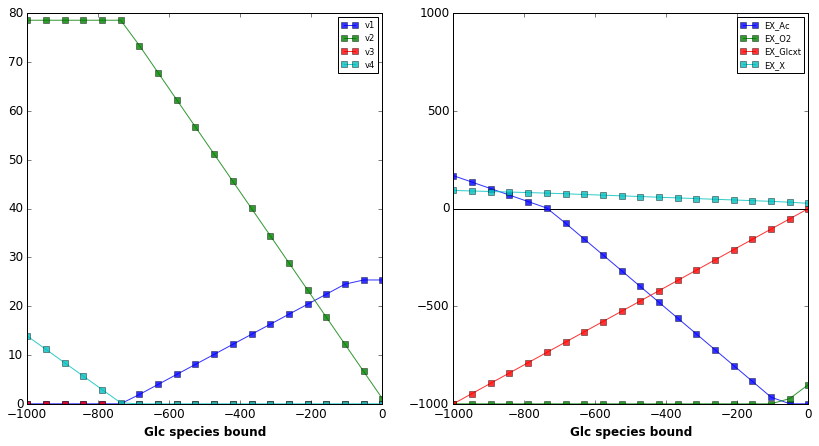

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

for vid in ['v1', 'v2', 'v3', 'v4']:
    ax1.plot(df.EX_Glcxt, df[vid], marker='s', alpha=0.8, label=vid)

ax2.plot([np.min(glc_bounds), np.max(glc_bounds)], [0, 0], color='k', linestyle='-', linewidth=1)
for vid in ['EX_Ac', 'EX_O2', 'EX_Glcxt', 'EX_X']:
    ax2.plot(df.EX_Glcxt, df[vid], marker='s', alpha=0.8, label=vid)
ax2.set_ylim(-1000, 1000)
    
for ax in [ax1, ax2]:
    ax.set_xlabel('Glc species bound')
    ax.legend()

plt.show()